<a href="https://colab.research.google.com/github/tdegamboda/Kaggle_Rough/blob/main/Customer_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Churn Analysis

A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

I got this dataset from a website with the URL as https://leaps.analyttica.com/home. I have been using this for a while to get datasets and accordingly work on them to produce fruitful results. The site explains how to solve a particular business problem.

Now, this dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

We have only 16.07% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers.

Work done in this notebook is based on work done by Thomas Konstantin

In [1]:
#Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json\

In [4]:
!kaggle datasets download -d sakshigoyal7/credit-card-customers

  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 58.8MB/s]


In [5]:
!pip install scikit-plot

## We will start by importing all necessary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
# pyo.init_notebook_mode()
# sns.set_style('darkgrid')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [7]:
data = pd.read_csv("credit-card-customers.zip", compression = 'zip', header = 0, sep = ",", quotechar='"')

data.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [8]:
# We will not be using the last two columns of this dataset hence we drop them

data = data[data.columns[:-2]]
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [9]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = data['Customer_Age'], name = 'Age Box Plot', boxmean = True)
tr2 = go.Histogram(x = data['Customer_Age'], name = 'Age Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Customer Ages")
fig.show()

We observe a generally normal distribution of the customer ages in our dataset hence we will use the age feature in further work under the normality assumption

In [10]:
fig1 = ex.pie(data, names = 'Gender', title = 'Proportion Of Customer Genders')
fig1.update_layout(height = 500, width = 700)
fig1.show()

Given that the distrubtion of males to females differ by 5.8% we can assume that the genders are uniformly distributed

In [11]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = data['Dependent_count'], name = 'Dependent Count Box Plot', boxmean = True)
tr2 = go.Histogram(x = data['Dependent_count'], name = 'Dependent Count Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Dependent Counts (Close Family Size)")
fig.show()

The distribution of dependent counts is fairly normally distributed with a slight right skew. On average, we can state that families have a dependent count of 2.

In [12]:
fig1 = ex.pie(data, names = "Education_Level", title = "Proportion of Education Levels")
fig1.update_layout(height = 500, width = 700)
fig1.show()

If we make the assumption that an "Unknown" education level referes to a lack of any formal education then we may state that more than 70% of the customers have a formal education level. From the proportion of clients with a formal education, we also note that 71.4% these clients have or are currently pursuing a higher level of education.

In [13]:
fig1 = ex.pie(data, names = "Marital_Status", title = "Proportion of Marital Statuses")
fig1.update_layout(height = 500, width = 700)
fig1.show()

The majority of clients at this bank are married. Generally the distribution of marital status is as expected based on global rates

In [14]:
fig1 = ex.pie(data, names = "Income_Category", title = "Proportion of Income Levels")
fig1.update_layout(height = 500, width = 700)
fig1.show()

In [15]:
fig1 = ex.pie(data, names = "Card_Category", title = "Proportion of Different Card Categories")
fig1.update_layout(height = 500, width = 700)
fig1.show()

It is interesting to compare the distribution of income bands to the card categories. It is evident that a staggering majority of clients use the Blue card even though the distribution of income levels vary. Only 6.8% of the bank clients use higher card tiers (above Blue) even though 7.8% of clients fall in the highest income group

In [16]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = data['Months_on_book'], name = 'Months on Book Box Plot', boxmean = True)
tr2 = go.Histogram(x = data['Months_on_book'], name = 'Months on Book Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Months on Book")
fig.show()

In [17]:
kurt = data['Months_on_book'].kurt()
print("Kurtosis of the distribution of months on books: {}".format(kurt))

Kurtosis of the distribution of months on books: 0.40010012019986707


The low kurtosis can be interpreted as an indication of a very flat shaped distribution. In this case we cannot assume the normality of the feature.

In [18]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = data['Total_Relationship_Count'], name = 'Total No. of Products Box Plot', boxmean = True)
tr2 = go.Histogram(x = data['Total_Relationship_Count'], name = 'Total No. of Products Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of the Total No. of Proucts Held by the Customer")
fig.show()

The distribution of the total number of products held by the customer has an irregular distribution. We can observe a uniform distribution where the total number of products is greater than 4 and a left skewed distribution everywhere else. This may suggest that this feature will be useless for the predictor of the churn status

In [19]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = data['Months_Inactive_12_mon'], name = 'No. of Months Inactive Box Plot', boxmean = True)
tr2 = go.Histogram(x = data['Months_Inactive_12_mon'], name = 'No. of Months Inactive Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of the Number of Months Inactive in the Last 12 Months")
fig.show()

In [20]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=data['Credit_Limit'],name='Credit_Limit Box Plot',boxmean=True)
tr2=go.Histogram(x=data['Credit_Limit'],name='Credit_Limit Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of the Credit Limit")
fig.show()

In [21]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=data['Total_Trans_Amt'],name='Total_Trans_Amt Box Plot',boxmean=True)
tr2=go.Histogram(x=data['Total_Trans_Amt'],name='Total_Trans_Amt Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of the Total Transaction Amount (Last 12 months)")
fig.show()

It is evident that the distribution of total transactions presents a multimodal distribution. Generally this can imply that we have some underlying groups in our data that can be clustered and further examined.

In [22]:
fig1 = ex.pie(data, names = "Attrition_Flag", title = "Proportion of Churn v. Not Churn Customers")
fig1.update_layout(height = 500, width = 700)
fig1.show()

Given that we have an uneven distribution of the two classes we will upsample the Attrited Customers. This will give the later selected models a better chance of catching on small details which will almost definitely be missed out with such a size difference.

Following the EDA we will now use a one hot encoding on all the categorical features

In [23]:
data.Attrition_Flag = data.Attrition_Flag.replace({'Attrited Customer' : 1, 'Existing Customer' : 0})
data.Gender = data.Gender.replace({'F' : 1, 'M' : 0})
data = pd.concat([data, pd.get_dummies(data.Education_Level).drop(columns = ['Unknown'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data.Income_Category).drop(columns = ['Unknown'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data.Marital_Status).drop(columns = ['Unknown'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data.Card_Category).drop(columns = ['Platinum'])], axis = 1)

data.drop(columns = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category', 'CLIENTNUM'], inplace = True)

In [24]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Divorced,Married,Single,Blue,Gold,Silver
0,0,45,0,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0,49,1,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,0,51,0,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,0,40,1,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,40,0,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0


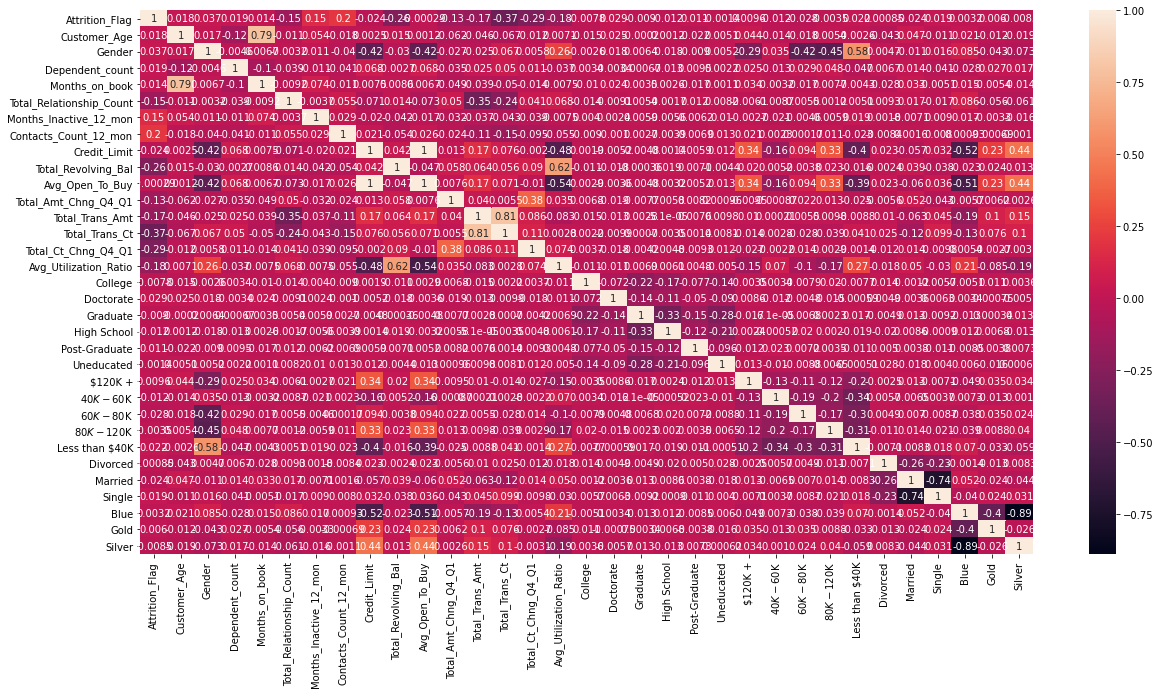

In [25]:
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr('pearson'), annot = True)

As discussed earlier we will apply an upsampling technique using SMOTE (Synthetic Minority Oversampling Technique) in this case. SMOTE considers feature sin the minority class in order to produce new synthetic data.

In [26]:
oversample = SMOTE()
X, y = oversample.fit_resample(data[data.columns[1:]], data[data.columns[0]])
usampled_df = pd.DataFrame(data = X, columns = data.columns[1:])
usampled_df = usampled_df.assign(Churn = y)
usampled_df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Divorced,Married,Single,Blue,Gold,Silver,Churn
0,45.0,0.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,49.0,1.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
2,51.0,0.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
3,40.0,1.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.760,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,40.0,0.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.500,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [27]:
ohe_data = usampled_df[usampled_df.columns[15 : -1]].copy()
usampled_df = usampled_df.drop(columns = usampled_df.columns[15 : -1])

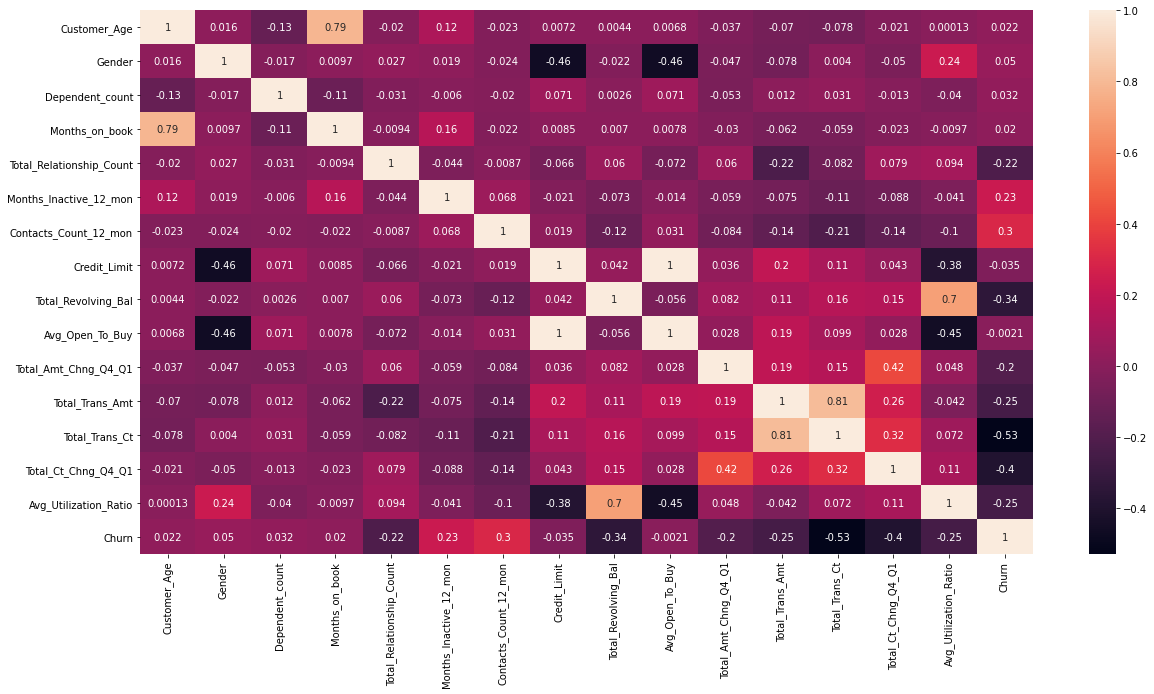

In [28]:
plt.figure(figsize = (20, 10))

sns.heatmap(usampled_df.corr('pearson'), annot = True)

Principal Component Analysis is used at this stage to reduce the dimensionality of the one-hot encoded categorical variables. This may lead to losing some of the variance but at the same time using a few principal components instead of the tens of one-hot encoded features will help construct a better model

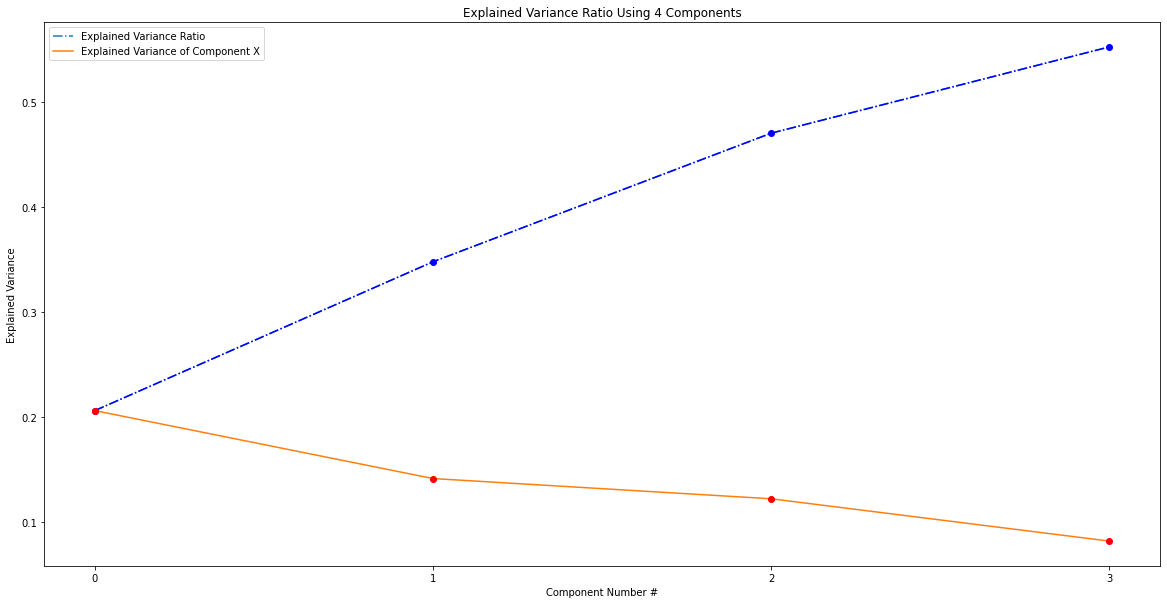

In [29]:
N_COMPONENTS = 4

pca_model = PCA(n_components = N_COMPONENTS)

pc_matrix = pca_model.fit_transform(ohe_data)

evr = pca_model.explained_variance_ratio_
cumsum_evr = np.cumsum(evr)

plt.figure(figsize = (20, 10))

ax = sns.lineplot(x = np.arange(0, len(cumsum_evr)), y = cumsum_evr, label = 'Explained Variance Ratio')
ax.lines[0].set_linestyle('-.')
ax.set_title('Explained Variance Ratio Using {} Components'.format(N_COMPONENTS))
ax.plot(np.arange(0, len(cumsum_evr)), cumsum_evr, 'bo')

ax = sns.lineplot(x = np.arange(0, len(evr)), y = evr, label = 'Explained Variance of Component X')
ax.plot(np.arange(0, len(evr)), evr, 'ro')
ax.lines[1].set_linestyle('-.')


ax.set_xticks([i for i in range(len(cumsum_evr))])
ax.set_xlabel("Component Number #")
ax.set_ylabel("Explained Variance")
plt.show()

In [30]:
usampled_df_with_pcs = pd.concat([usampled_df, pd.DataFrame(data = pc_matrix, columns = ['PC-{}'.format(i) for i in range(N_COMPONENTS)])], axis = 1)
usampled_df_with_pcs.head()

,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn,PC-0,PC-1,PC-2,PC-3
0,45.0,0.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061,0,-0.708617,-0.501458,-0.478165,0.080543
1,49.0,1.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105,0,0.761311,0.853571,0.509300,-0.023408
2,51.0,0.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.000,0,-0.706121,-0.197922,0.818819,0.591262
3,40.0,1.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.760,0,0.049873,0.496129,-0.761183,-0.079402
4,40.0,0.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.500,0.000,0,-0.669233,-0.422478,-0.231067,0.233276


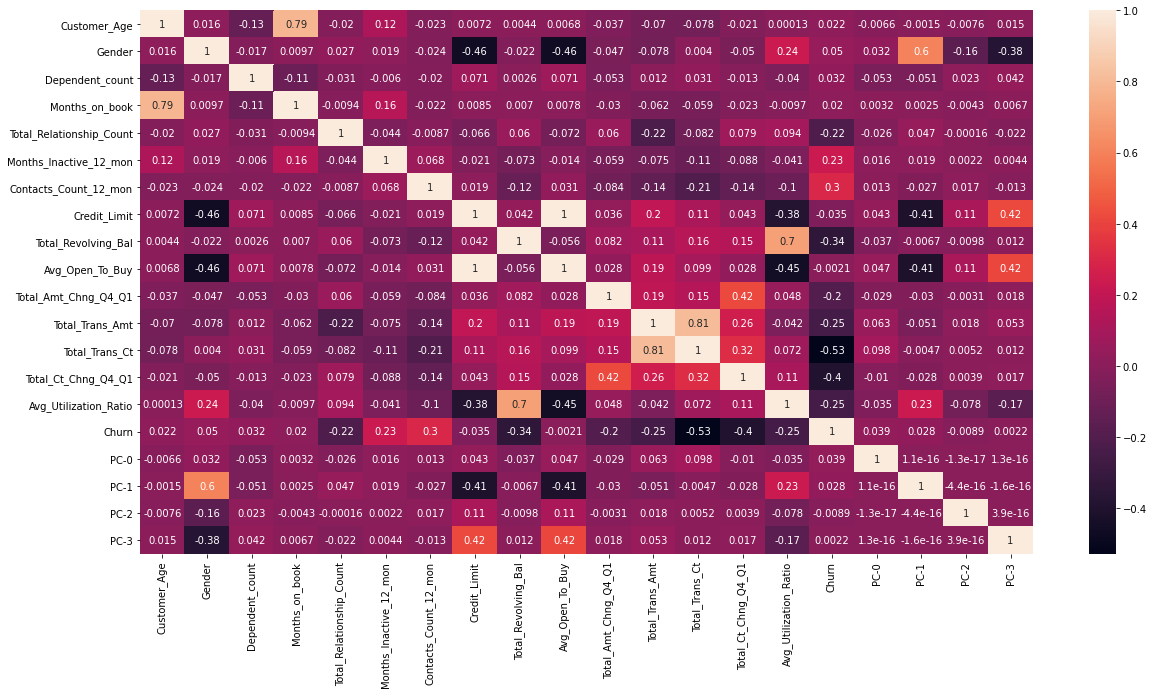

In [31]:
plt.figure(figsize = (20, 10))
sns.heatmap(usampled_df_with_pcs.corr('pearson'), annot = True)

Next with reference to the heatmap and the Pearson correlation coeffecient scores we will selecct the features which are most correlated to the Churn variable. Likewise we will make use of all the principal components as these 4 features best represent the categorical features in our data while reducing computational cost

In [32]:
usampled_df_with_pcs.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn', 'PC-0', 'PC-1', 'PC-2', 'PC-3'],
      dtype='object')

In [45]:
features = ['Total_Trans_Ct', 'PC-0', 'PC-1', 'PC-2', 'PC-3', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count']


X = usampled_df_with_pcs[features]
y = usampled_df_with_pcs['Churn']

In [46]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 2020)

In [44]:
rf_pipe = Pipeline(steps = [('scale', StandardScaler()), ('rf', RandomForestClassifier(random_state=2020))])
ada_pipe = Pipeline(steps = [('scale', StandardScaler()), ('ada', AdaBoostClassifier(random_state=2020, learning_rate=0.7))])
svm_pipe = Pipeline(steps = [('scale', StandardScaler()), ('svc', SVC(random_state=2020, kernel = 'rbf'))])

folds = 5

f1_cross_val_scores = cross_val_score(rf_pipe,train_X,train_y,cv=folds,scoring='f1')
ada_f1_cross_val_scores=cross_val_score(ada_pipe,train_X,train_y,cv=folds,scoring='f1')
svm_f1_cross_val_scores=cross_val_score(svm_pipe,train_X,train_y,cv=folds,scoring='f1')

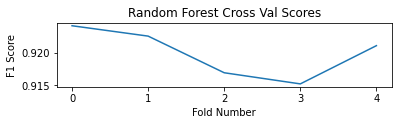

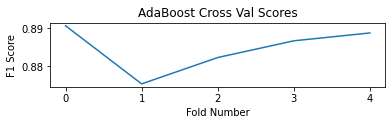

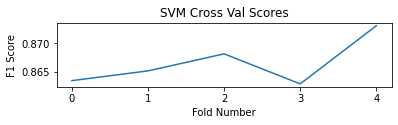

In [57]:
plt.subplot(311)
ax = sns.lineplot(x = np.arange(folds), y = f1_cross_val_scores)
ax.set_title("Random Forest Cross Val Scores")
ax.set_xticks([i for i in range(folds)])
ax.set_xlabel("Fold Number")
ax.set_ylabel("F1 Score")

plt.show()

plt.subplot(312)
ax = sns.lineplot(x = np.arange(folds), y = ada_f1_cross_val_scores)
ax.set_title("AdaBoost Cross Val Scores")
ax.set_xticks([i for i in range(folds)])
ax.set_xlabel("Fold Number")
ax.set_ylabel("F1 Score")

plt.show()

plt.subplot(313)
ax = sns.lineplot(x = np.arange(folds), y = svm_f1_cross_val_scores)
ax.set_title("SVM Cross Val Scores")
ax.set_xticks([i for i in range(folds)])
ax.set_xlabel("Fold Number")
ax.set_ylabel("F1 Score")

plt.show()

In [59]:
rf_pipe.fit(train_X, train_y)
rf_prediction = rf_pipe.predict(test_X)

ada_pipe.fit(train_X,train_y)
ada_prediction = ada_pipe.predict(test_X)

svm_pipe.fit(train_X,train_y)
svm_prediction = svm_pipe.predict(test_X)

print('F1 Score of Random Forest Model On Test Set - {}'.format(f1_score(rf_prediction,test_y)))
print('F1 Score of AdaBoost Model On Test Set - {}'.format(f1_score(ada_prediction,test_y)))
print('F1 Score of SVM Model On Test Set - {}'.format(f1_score(svm_prediction,test_y)))

F1 Score of Random Forest Model On Test Set - 0.9244296577946769
F1 Score of AdaBoost Model On Test Set - 0.8939010356731877
F1 Score of SVM Model On Test Set - 0.8681914642772931


We will now evaluate the trained models on the original data that does not contain any of the synthetic data.

In [64]:
ohe_data = data[data.columns[16:]].copy()
pc_matrix = pca_model.fit_transform(ohe_data)
original_df_with_pcs = pd.concat([data, pd.DataFrame(data = pc_matrix, columns = ['PC-{}'.format(i) for i in range(N_COMPONENTS)])], axis = 1)

unsampled_data_prediction_RF = rf_pipe.predict(original_df_with_pcs[features])
unsampled_data_prediction_ADA = ada_pipe.predict(original_df_with_pcs[features])
unsampled_data_prediction_SVM = svm_pipe.predict(original_df_with_pcs[features])

In [65]:
print('F1 Score of Random Forest Model On Original Data (Before Upsampling) - {}'.format(f1_score(unsampled_data_prediction_RF,original_df_with_pcs['Attrition_Flag'])))
print('F1 Score of AdaBoost Model On Original Data (Before Upsampling) - {}'.format(f1_score(unsampled_data_prediction_ADA,original_df_with_pcs['Attrition_Flag'])))
print('F1 Score of SVM Model On Original Data (Before Upsampling) - {}'.format(f1_score(unsampled_data_prediction_SVM,original_df_with_pcs['Attrition_Flag'])))

F1 Score of Random Forest Model On Original Data (Before Upsampling) - 0.7112731059619891
F1 Score of AdaBoost Model On Original Data (Before Upsampling) - 0.5751550138977978
F1 Score of SVM Model On Original Data (Before Upsampling) - 0.5781614559029399


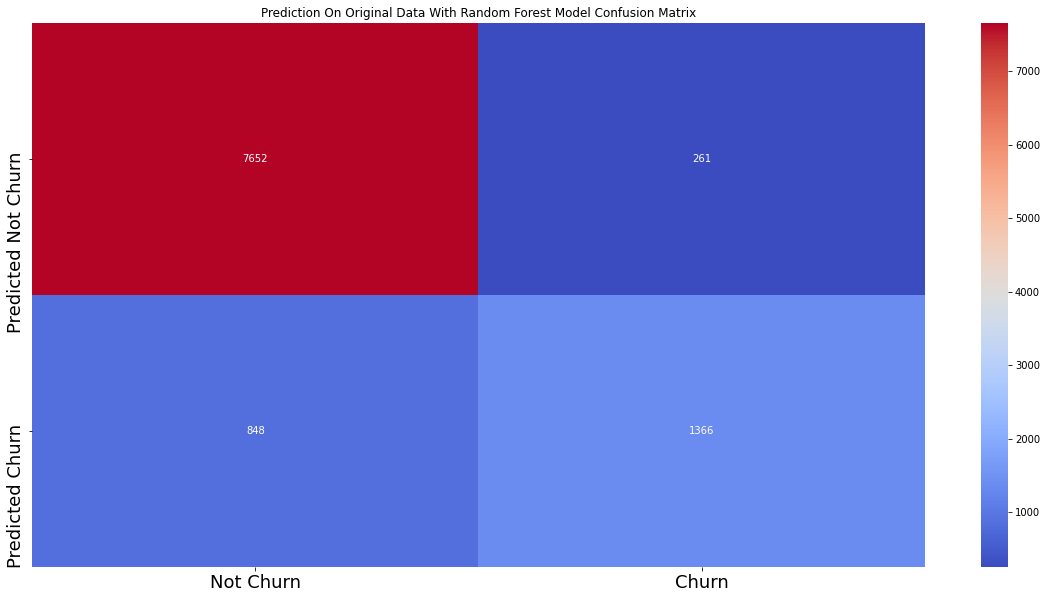

In [67]:
plt.figure(figsize=(20, 10))

ax = sns.heatmap(confusion_matrix(unsampled_data_prediction_RF,original_df_with_pcs['Attrition_Flag']),annot=True,cmap='coolwarm',fmt='d')
ax.set_title('Prediction On Original Data With Random Forest Model Confusion Matrix')
ax.set_xticklabels(['Not Churn','Churn'],fontsize=18)
ax.set_yticklabels(['Predicted Not Churn','Predicted Churn'],fontsize=18)

plt.show()

<Figure size 1440x720 with 0 Axes>

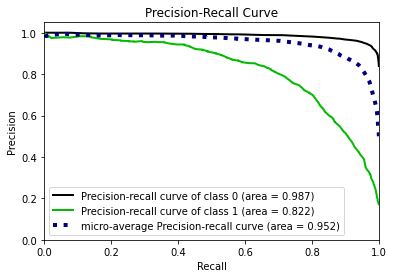

In [70]:
plt.figure(figsize = (20, 10))

unsampled_data_prediction_RF = rf_pipe.predict_proba(original_df_with_pcs[features])
skplt.metrics.plot_precision_recall(original_df_with_pcs['Attrition_Flag'], unsampled_data_prediction_RF)

## Notes



*   F1 is useful in the context where we are not particularly concerned about the true negatives
*   Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds
*   ROC curves summarize the trade-off between the true positive rate and the false positive rate for a predictive model using different probability thresholds
*   ROC curves should be used when there are roughly equal numbers of observations for each class
*   Precision-Recall curves should be used when there is a moderate to large class imbalance
*   The reason for this recommendation is that ROC curves present an optimistic picture of that model on datasets with a class imbalance










